---
# **LAB 7 - Audio Classification**
---

In [5]:
import os

# dirs
base_dir = './AUDIO_IN' 
wav_dir = os.path.join(base_dir, 'wav/') 
data_dir = os.path.join(base_dir, 'data/') 
out_dir = os.path.join(base_dir, 'output/') 

# print base dir 
print("Current dir:", os.getcwd())

Current dir: c:\Users\eumir\Desktop\Università\Anno III\Semestre 1\Informazione Multimediale\AUDIO


# ▶️ Classes and functions

In [3]:
import numpy as np
import os
import sklearn
from sklearn.preprocessing import scale
import librosa
import librosa.display
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from pydub import AudioSegment
from torch import nn

# local libraries
from src.pyaudio2 import *
from src.pyaudio3 import *
from src.pyaudio4 import *
from src.pyaudio5 import *
from src.utils import *

###################################
# Mel spect. & MFCC coeff.
###################################

def mel_spectrogram(x, sr, n_fft=2048, hop_length=512, n_mels=40):

  mel_sp = librosa.feature.melspectrogram(y=x, 
                                          sr=sr, 
                                          n_fft=n_fft, 
                                          hop_length=hop_length, 
                                          n_mels=n_mels)
  print('Mel spectrogram shape =', mel_sp.shape)
  log_mel_sp = librosa.power_to_db(mel_sp)

  return mel_sp, log_mel_sp

def plot_log_mel_spectrogram(log_mel_spect, sr):
  plt.figure(figsize=(25, 10))
  librosa.display.specshow(log_mel_spect, 
                          x_axis="time",
                          y_axis="mel", 
                          sr=sr)
  plt.show()

def mel_filter_banks(n_fft=2048, sr=22050, n_mels=10):
  filter_banks = librosa.filters.mel(n_fft=n_fft, sr=sr, n_mels=n_mels)
  print('filter banks shape =', filter_banks.shape)
  
  return filter_banks

def plot_filter_banks(filter_banks, sr):
  plt.figure(figsize=(25, 10))
  librosa.display.specshow(filter_banks, 
                          sr=sr, 
                          x_axis="linear")
  plt.colorbar(format="%+2.f")
  plt.show()

def MFCC(x, sr, n_mfcc=20, scaled=False):
  mfccs = librosa.feature.mfcc(y=x, n_mfcc=n_mfcc, sr=sr)
  # zero mean and unit variance
  if 'scaled':
    mfccs = scale(mfccs, axis=1)
  print('MFCC shape =', mfccs.shape)
  return mfccs

def plot_MFCC(mfccs, sr):
  plt.figure(figsize=(25, 10))
  librosa.display.specshow(mfccs, x_axis="time", sr=sr)
  plt.colorbar(format="%+2.f")
  plt.show()

###################################
# CNN for classification
###################################

def selected_files(out_filename, ANNOTATIONS_FILE, AUDIO_DIR):
  """
    Load annotation file (ANNOTATIONS_FILE) and save a table of 
    pairs (filename, classID) from AUDIO_DIR on a output file 'out_filename'
  """
  df = pd.read_csv(ANNOTATIONS_FILE)
  fnames = []
  cls = []
  for index, row in df.iterrows():
    row['filename'] = x = row['filename'].replace("wav", "mp3")
    fname = AUDIO_DIR + '/' + 'fold'+ str(row['fold']) + '/' + row['filename']
    if os.path.isfile(fname):
      fnames.append(fname)
      cls.append(row['classID'])

  # save
  df = pd.DataFrame({'slice_file_name':fnames, 'classID':cls})
  df.to_csv(out_filename)

class CNN(nn.Module):

    def __init__(self):
        super().__init__()
        # 4 conv blocks / flatten / linear / softmax
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(128 * 5 * 6, 128)
        self.tanh = nn.Tanh()
        self.linear2 = nn.Linear(128, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.tanh(x)
        logits = self.linear2(x)
        #print('logits shape', logits.shape)
        predictions = self.softmax(logits)
        #print('predictions shape', predictions.shape)
        return predictions

def create_data_loader(train_data, batch_size):
    train_dataloader = DataLoader(train_data, batch_size=batch_size)
    return train_dataloader

def training_test_sets(audio_filenames, train_frac=0.5, random_state=25):
  df = pd.read_csv(audio_filenames) # load in pandas
  training_data = df.sample(frac=train_frac, random_state=random_state)
  testing_data = df.drop(training_data.index)
  print(f"No. of training examples: {training_data.shape[0]}")
  training_data['classID'].value_counts().plot(kind='bar', xlabel='classes', ylabel='Count', rot=0)
  plt.show()
  print(f"No. of testing examples: {testing_data.shape[0]}")
  testing_data['classID'].value_counts().plot(kind='bar', xlabel='classes', ylabel='Count', rot=0)
  plt.show()
  return training_data, testing_data

class_mapping = [
    "air_conditioner",
    "car_horn",
    "children_playing",
    "dog_bark",
    "drilling",
    "engine_idling",
    "gun_shot",
    "jackhammer",
    "siren",
    "street_music"]

class UrbanSoundDataset(Dataset):
  def __init__(self,
              data_file,
              audio_dir,
              num_samples,
              device):
    self.data = data_file
    self.audio_dir = audio_dir
    self.device = device
    self.num_samples = num_samples

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    audio_filename = self.audio_dir + self.data.iloc[index, 1]
    label = self.data.iloc[index, 2]

    # extract mp3 signal and normalize
    song = AudioSegment.from_mp3(audio_filename)
    signal = np.array(song.get_array_of_samples(), dtype=np.float32)
    signal = signal/np.max(np.abs(signal))
    signal = self._cut_if_necessary(signal)
    signal = self._right_pad_if_necessary(signal)
    
    # mel spectrogram
    mel = self.mel_spectrogram(signal)
    mel = mel.astype(np.float32)
    #plt.imshow(mel)
    #plt.show()
    return torch.from_numpy(mel), label

  def set_mel_spectrogram(self, sr, n_fft=1024, hop_length=256, n_mels=64):
    self.sr = sr
    self.n_fft = n_fft
    self.hop_length = hop_length
    self.n_mels = n_mels

  def mel_spectrogram(self, signal):
    mel_sp = librosa.feature.melspectrogram(y=signal, 
                                            sr=self.sr, 
                                            n_fft=self.n_fft, 
                                            hop_length=self.hop_length, 
                                            n_mels=self.n_mels, )
    return librosa.power_to_db(mel_sp)

  def _cut_if_necessary(self, signal):
    if signal.shape[0] > self.num_samples:
        signal = signal[:self.num_samples]
    return signal

  def _right_pad_if_necessary(self, signal):
    length_signal = signal.shape[0]
    if length_signal < self.num_samples:
        miss = self.num_samples - length_signal
        signal = np.append(signal, np.zeros(miss))
    return signal

def train(model, data_loader, loss_fn, optimiser, device, epochs):
  for i in range(epochs):
    print(f"Epoch {i+1}")
    for input, target in data_loader:
      input, target = input.to(device), target.to(device)
      # calculate loss
      s = input.shape
      input = torch.reshape(input, (s[0], 1, s[1], s[2]))
      prediction = model(input)
      #print('predict = ', prediction.shape)
      loss = loss_fn(prediction, target)
      #print(f'loss = {loss.item()} predict = {prediction} target = {target}')
      # backpropagate error and update weights
      optimiser.zero_grad()
      loss.backward()
      optimiser.step()

    print(f"loss: {loss.item()}")
    print("---------------------------")
  print("Finished training")

def predict_single(model, input, target, class_mapping, device):
  with torch.no_grad():
    input = input.to(device)
    predictions = model(input)
    predicted_index = predictions[0].argmax(0)
    predicted = class_mapping[predicted_index]
    expected = class_mapping[target]
  return predicted, expected

def predict(usd, model, device, class_mapping):
  model.eval()
  total = 0
  correct = 0
  for i in range(len(usd)):
      input, target = usd[i][0], usd[i][1]
      # make an inference
      s = input.shape
      input = torch.reshape(input, (1, 1, s[0], s[1]))
      predicted, expected = predict_single(model, input, target, class_mapping, device)
      total += 1
      correct += int(predicted == expected)
      print(f"Predicted: '{predicted}', expected: '{expected}'")
  print("Accuracy: %f", correct / total)


# ✅ Mel spectrogram

----------
Source: audio wav
----------
Sample Rate  : 22050 Hz
Sample width : 2 bytes
Quantiz. bits: 16
Num frames   : 73029
Dtype:  float32
 - Max:      0.981
 - Min:     -1.000
 - Mean:    -0.000
 - Std Dev:  0.220

Data:  [0.00337957 0.00358134 0.00322825 ... 0.01372005 0.01205549 0.0104918 ]



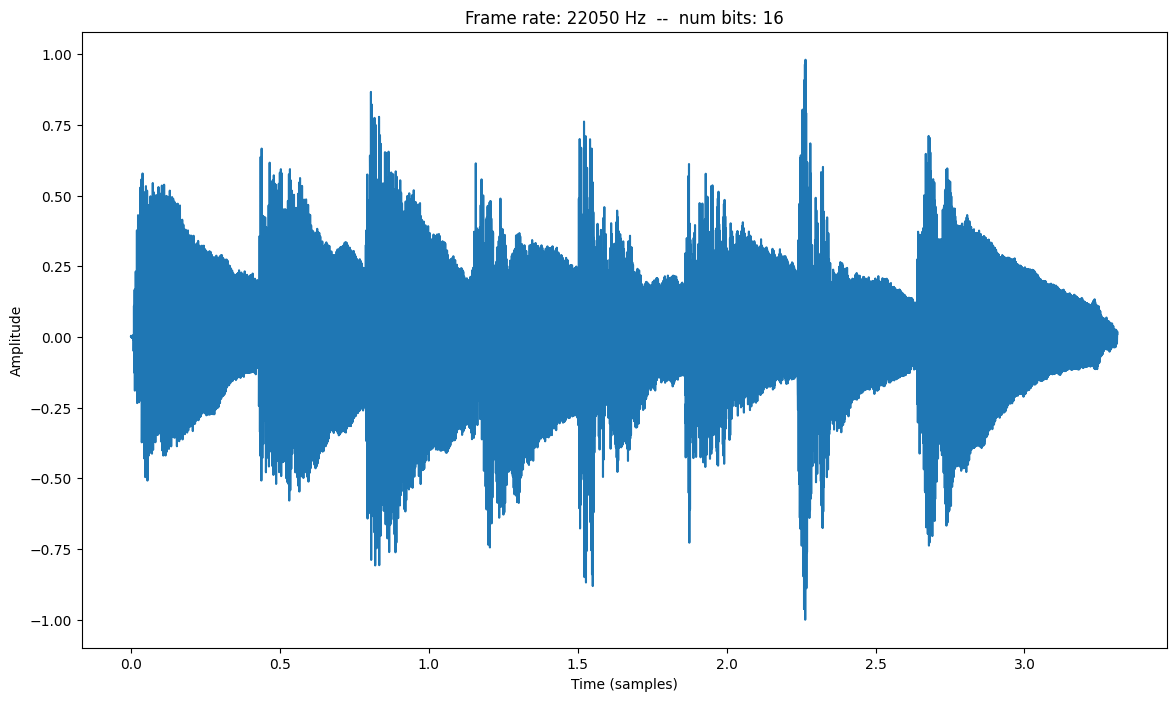

Pxx shape: (513, 141)


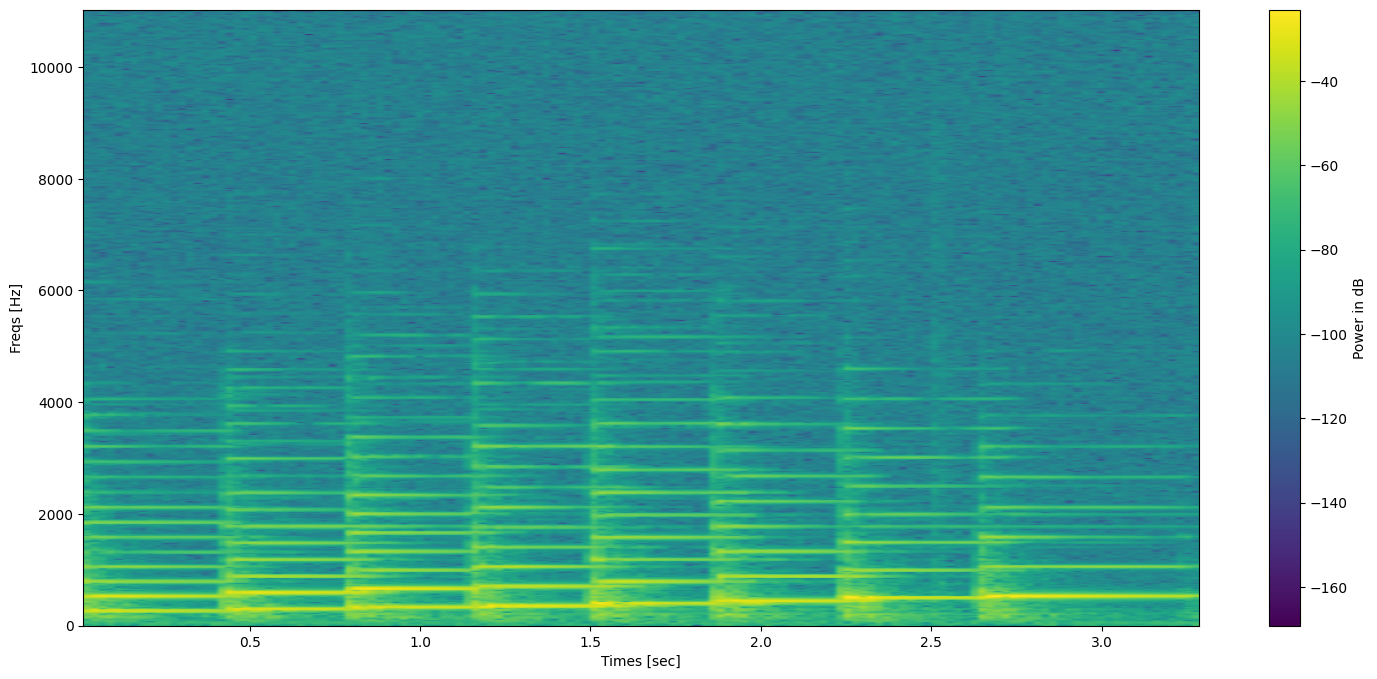

In [6]:
# waveform of a C major scale played by the Piano
C_scale_file = wav_dir + 'C-major-scale.wav'
a = Audio()
a.read_wav(C_scale_file)
a.play()
a.plot()

# extract digital signal
C_scale = a.get_Digital()  # get the wave signal of type Digital
C_scale.name = 'C-major-scale'
sr = C_scale.Fs  # sample rate
x = C_scale.x    # signal (numpy array)  

# scpectrogram
freqs, times, Pxx = spectrogram(x, sr, nperseg=1024, noverlap=512)
print('Pxx shape:', Pxx.shape )
plot_spectrogram(x, sr, nfft=1024, noverlap=512)

filter banks shape = (10, 513)


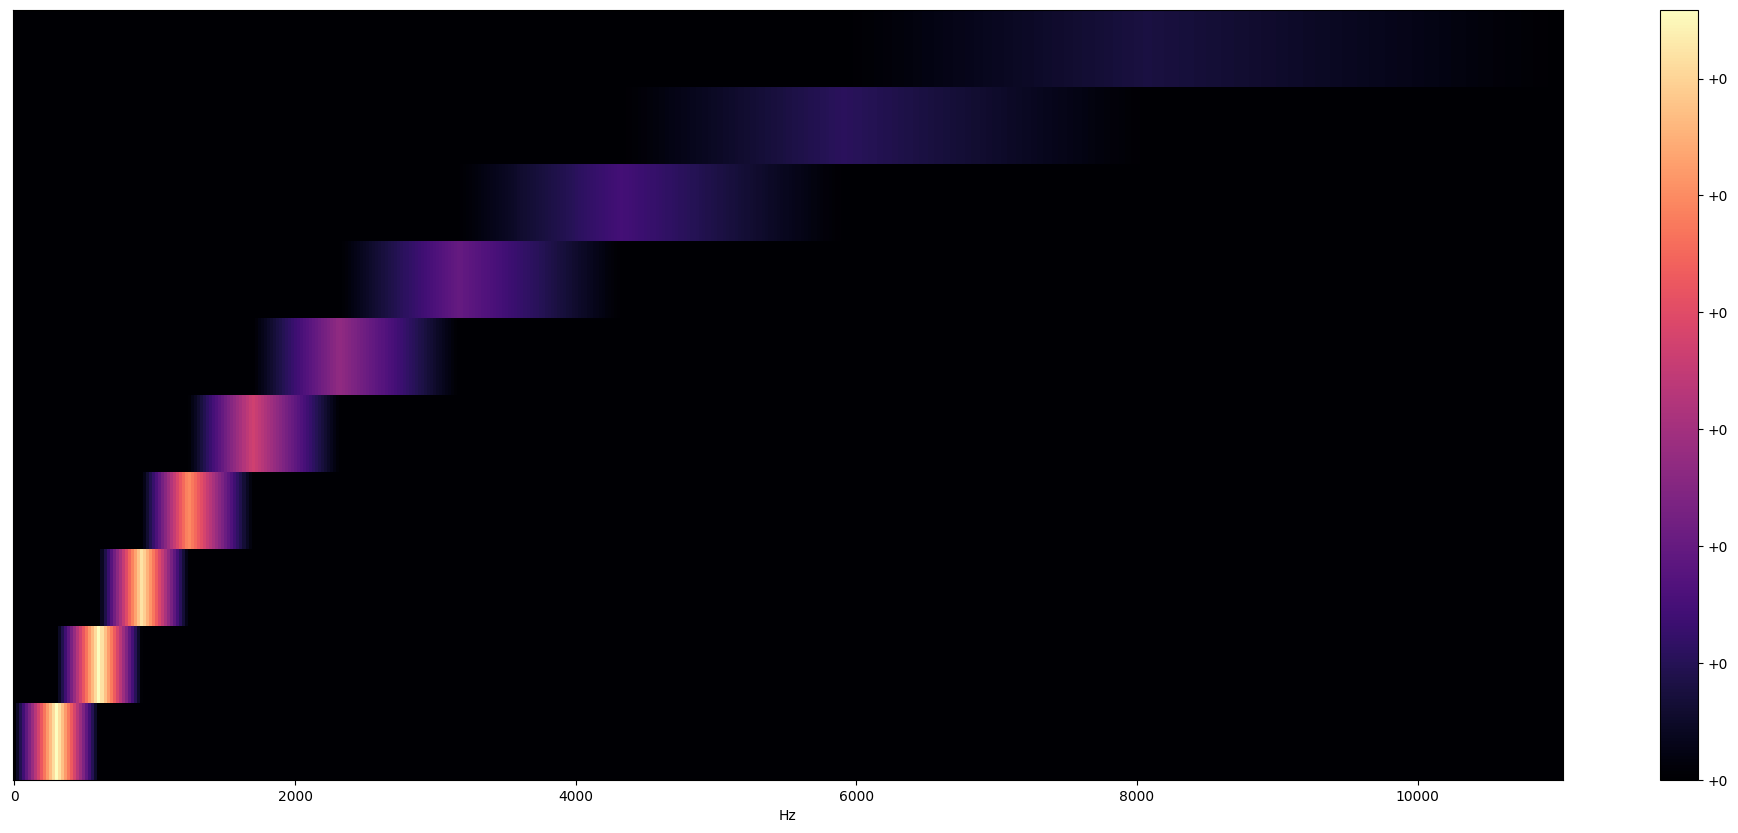

In [7]:

filter_banks = mel_filter_banks(n_fft=1024, sr=sr, n_mels=10)
plot_filter_banks(filter_banks, sr)

Mel spectrogram shape = (40, 143)


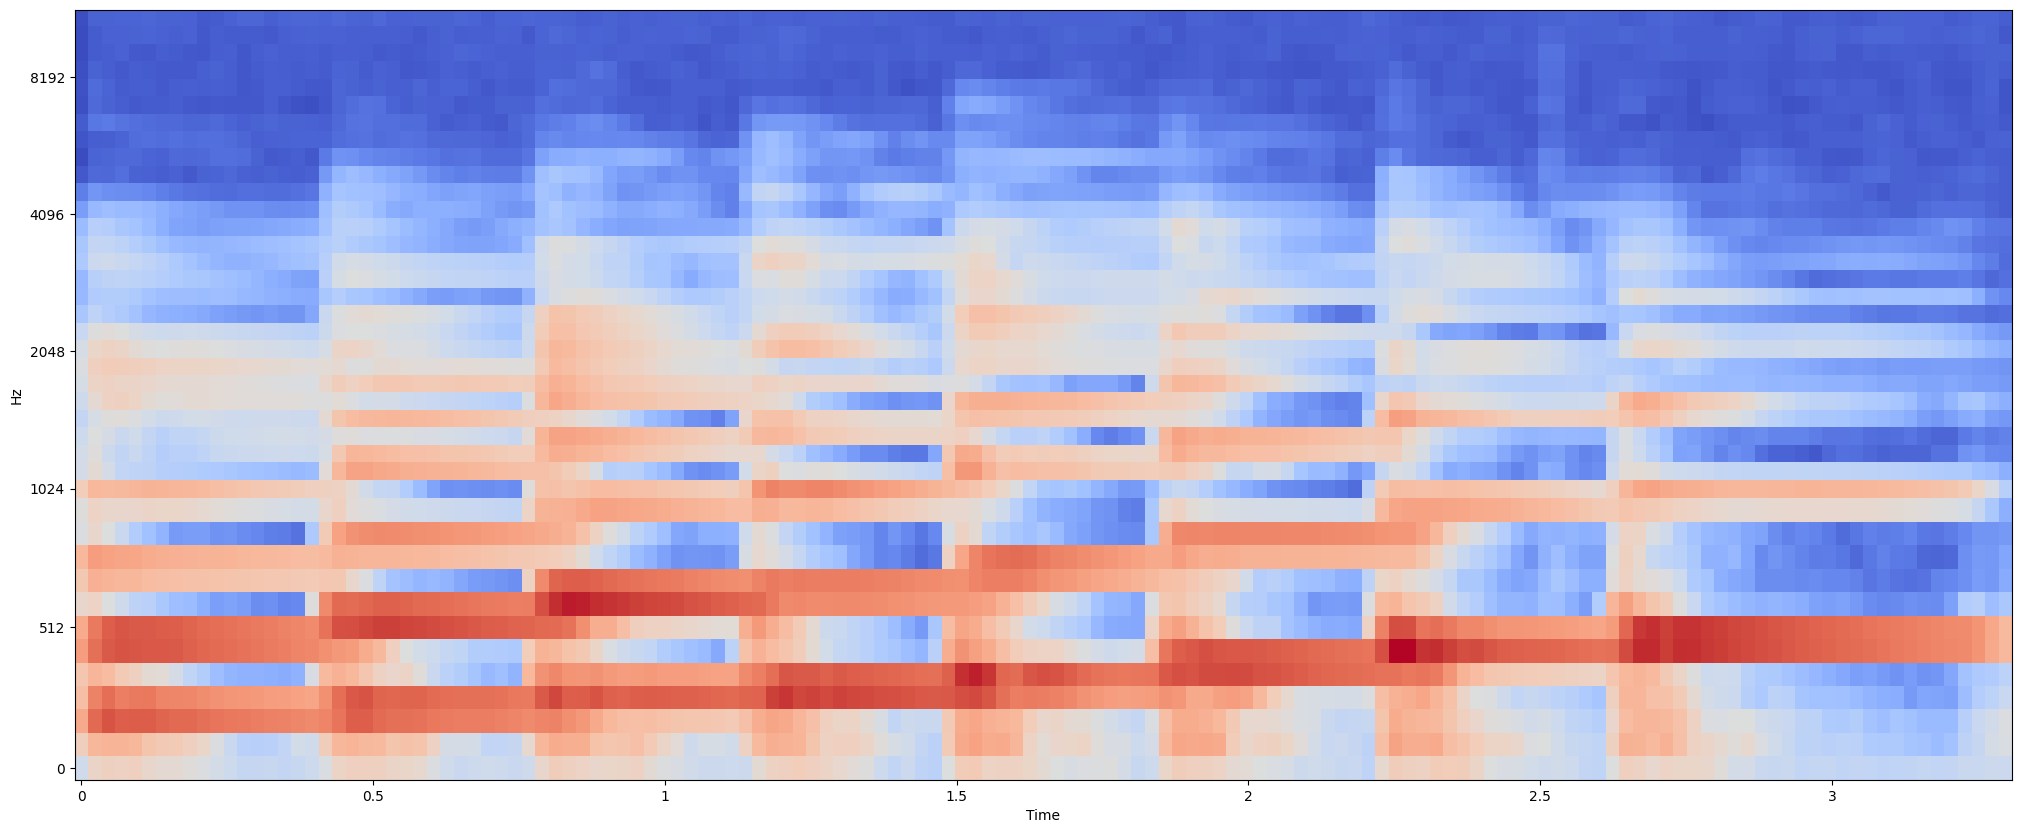

In [8]:
mel_spect, log_mel_spect = mel_spectrogram(x, sr, n_fft=2048, hop_length=512, n_mels=40)
plot_log_mel_spectrogram(log_mel_spect, sr)

# ✅ MFCC

C:\Users\eumir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
C:\Users\eumir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


MFCC shape = (13, 143)


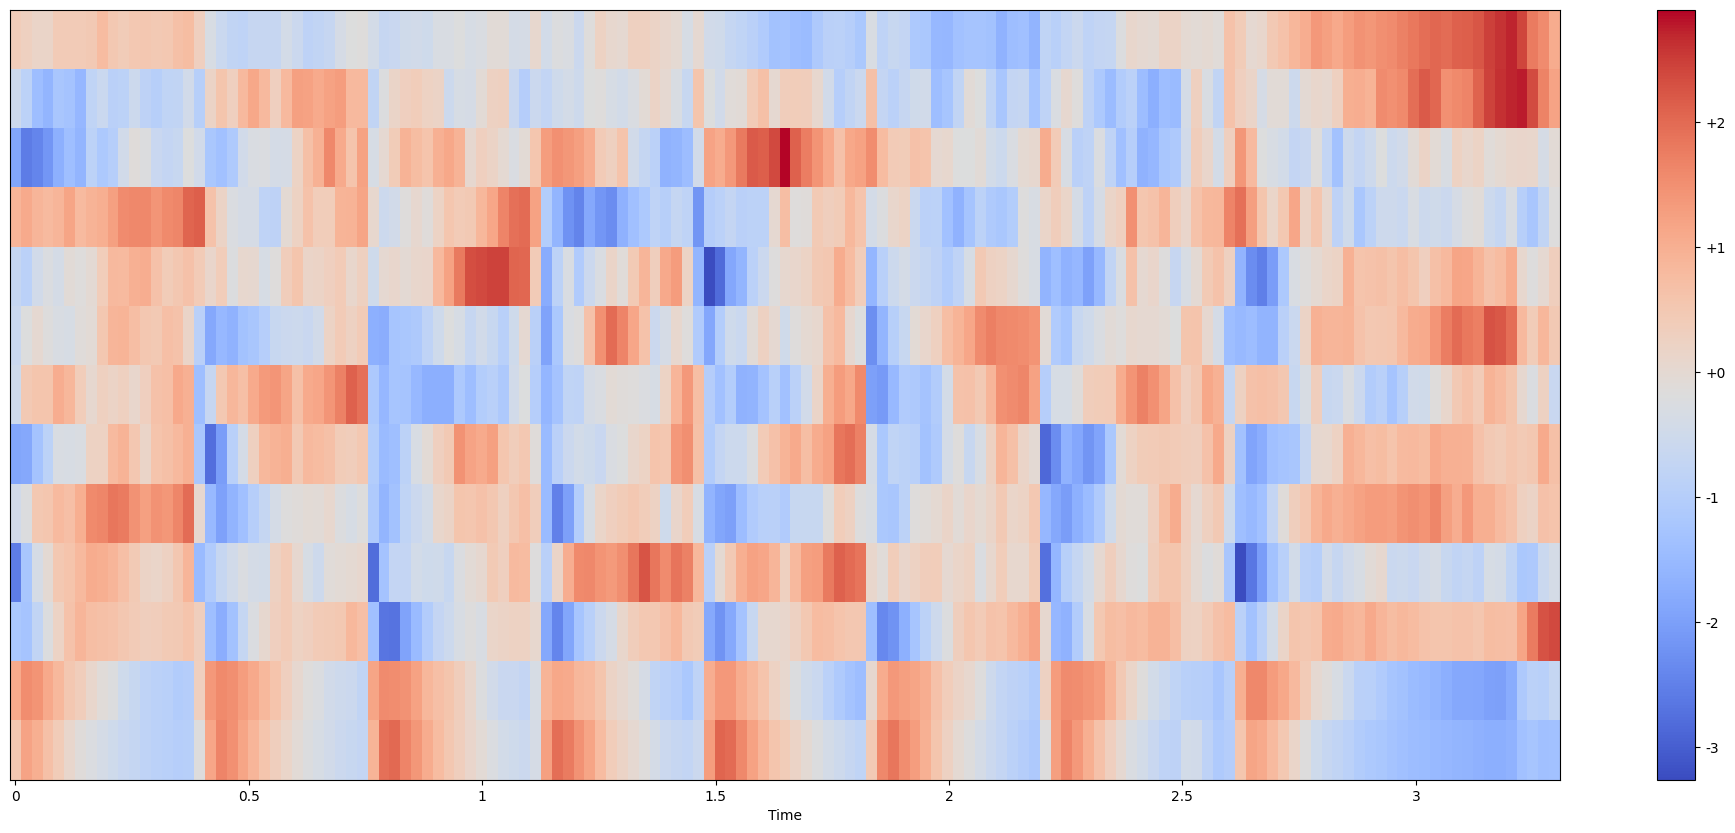

In [9]:
# MFCC computation and plot

mfccs = MFCC(x, sr, n_mfcc=13)
plot_MFCC(mfccs, sr)

## 🔴 TODO

* Apply previous analysis to `speech1.wav` signal

----------
Source: audio wav
----------
Sample Rate  : 44100 Hz
Sample width : 2 bytes
Quantiz. bits: 16
Num frames   : 107345
Dtype:  float32
 - Max:      1.000
 - Min:     -0.949
 - Mean:     0.004
 - Std Dev:  0.186

Data:  [0.         0.         0.         ... 0.00828746 0.00852424 0.00781389]



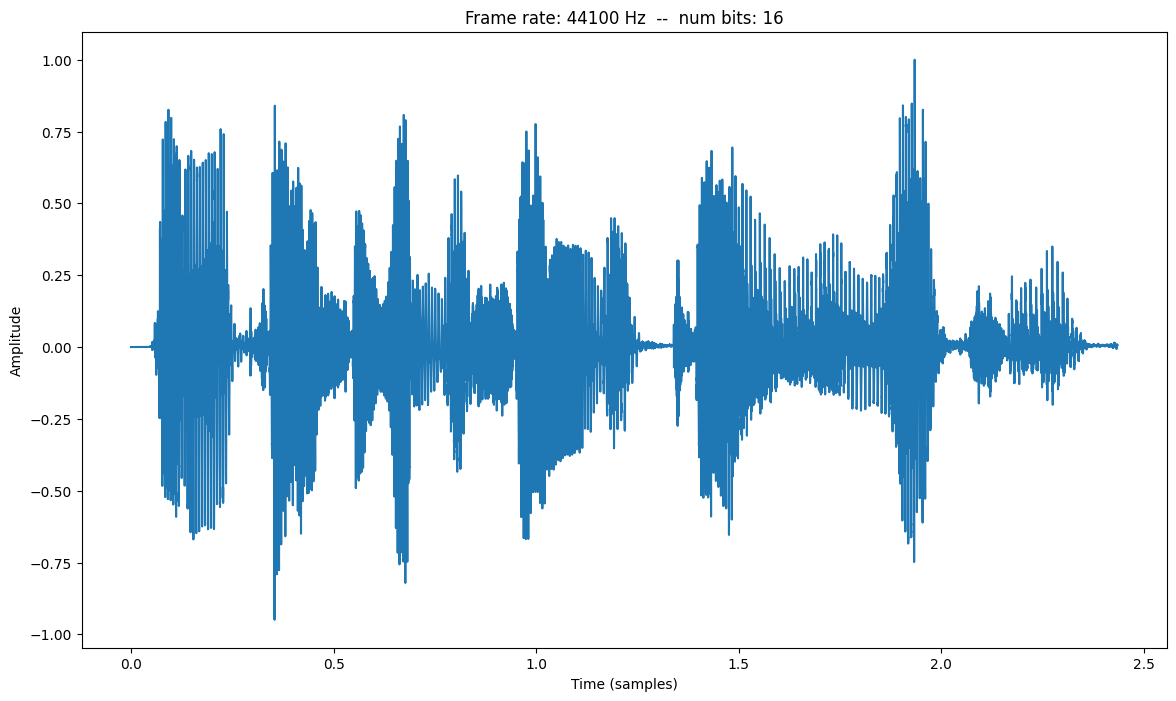

Mel spectrogram shape = (40, 210)


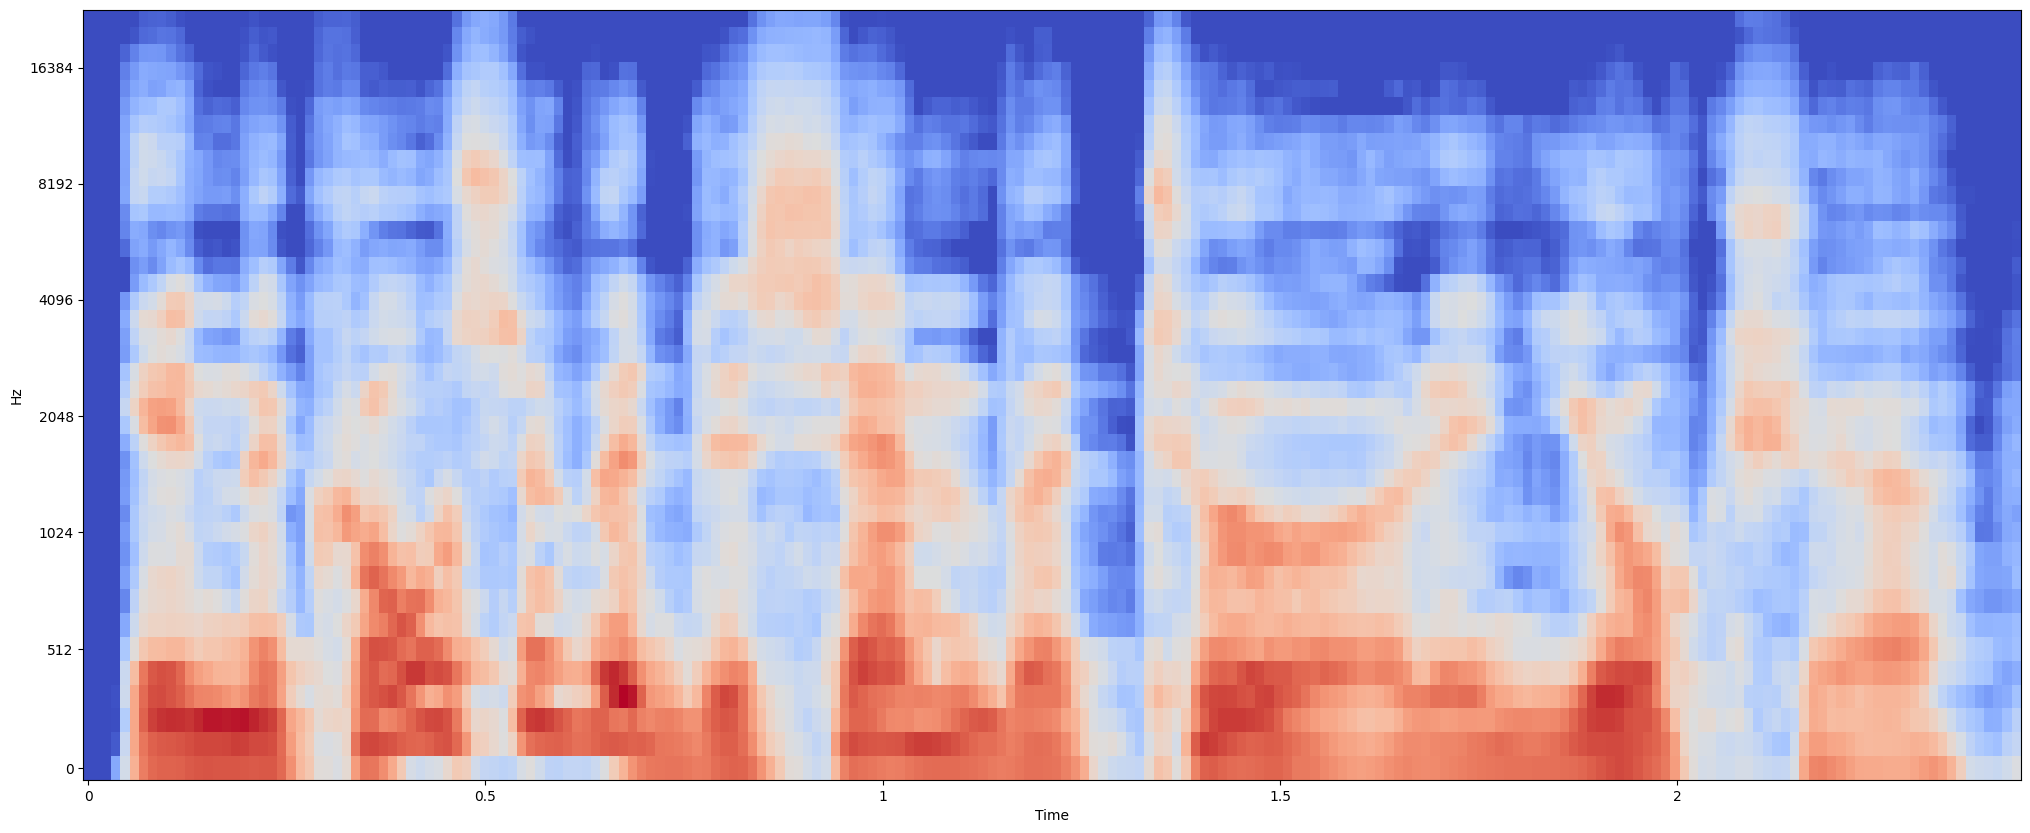

C:\Users\eumir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
C:\Users\eumir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


MFCC shape = (13, 210)


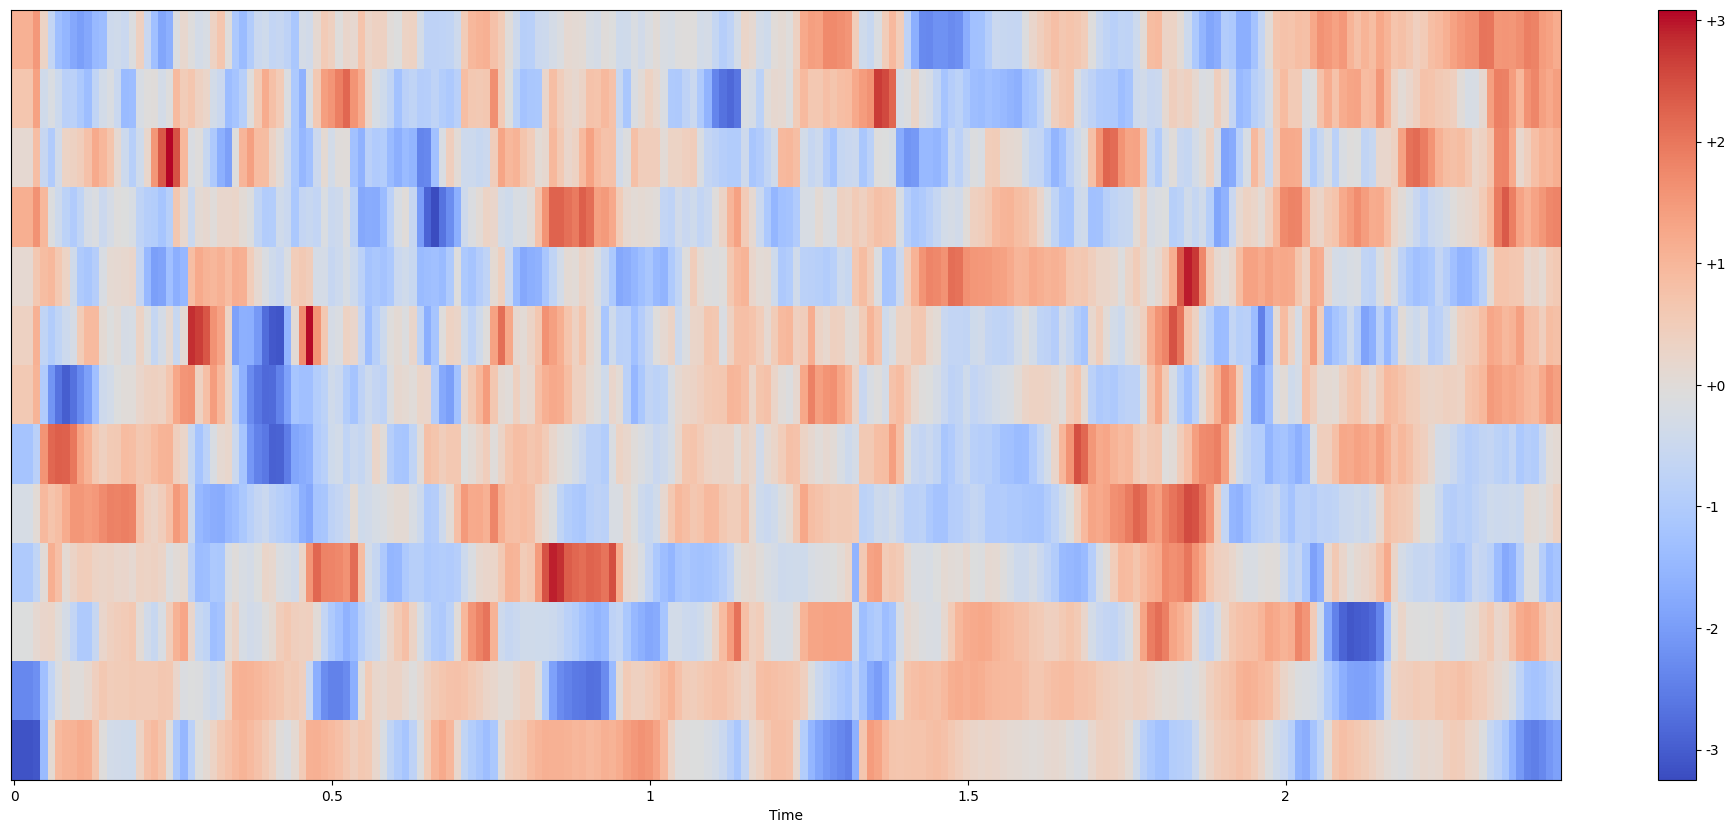

In [11]:
#### TODO

# Load signal
C_scale_file = wav_dir + 'speech3.wav'
a = Audio()
a.read_wav(C_scale_file)
a.play()
a.plot()

# extract digital signal
C_scale = a.get_Digital()  # get the wave signal of type Digital
C_scale.name = 'C-major-scale'
sr = C_scale.Fs  # sample rate
x = C_scale.x    # signal (numpy array)  

# mel spectrogram
mel_spect, log_mel_spect = mel_spectrogram(x, sr, n_fft=2048, hop_length=512, n_mels=40)
plot_log_mel_spectrogram(log_mel_spect, sr)

# MFCC
mfccs = MFCC(x, sr, n_mfcc=13)
plot_MFCC(mfccs, sr)

# ✅ CNN for classifcation

**URBANSOUND8K DATASET**

This dataset contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: `air_conditioner`, `car_horn`, `children_playing`, `dog_bark`, `drilling`, `enginge_idling`, `gun_shot`, `jackhammer`, `siren`, and `street_music`. 

**Files**

The folder `UrbanSound8K`contains two folders:
* `metadata`: with `UrbanSound8K.csv` listing the audio files with the classes, and the saved model `feedforwardnet.pth` 
* `audio`: containing 10 folds with the audio files in `mp3` format shuffled 

**Downloading**

The whole datasets can be downloaded [here](https://phuselab.di.unimi.it/resources/datasets/UrbanSound8K/UrbanSound8K.zip)

**Params definition**

* `SAMPLE_RATE`: sample rate of audio files
* `NUM_SAMPLES`: the number of audio samples to take, audio signals are of different lengths and a uniform final length is required


In [ ]:
### params
dataset_dir     = "/Users/grossi/datasets/"  # absolute path to the root of the dataset
audio_filenames = dataset_dir + "UrbanSound8K/metadata/UrbanSound8K.csv" # path to file list (pandas)
audio_dir       = dataset_dir + "UrbanSound8K/audio/"  # path to audio mp3 files

SAMPLE_RATE     = 8000
NUM_SAMPLES      = SAMPLE_RATE*5   # take only 4 seconds

**Training and tests sets**

When fitting machine learning models to datasets, we often split the dataset into two sets:

1. **Training Set**: Used to train the model (70-80% of original dataset)

2. **Testing Set**: Used to get an unbiased estimate of the model performance (20-30% of original dataset)

In Python, there are two common ways to split a pandas DataFrame into a training set and testing set:
```
train = df.sample(frac=0.8,random_state=0)
test = df.drop(train.index)
```
PS. `random_state` makes the example reproducible


In [ ]:
# training and test set
random_state = 0
training_data, testing_data = training_test_sets(audio_filenames, train_frac=0.5, random_state=random_state)
training_data

**Mel Spectrograms**

A Mel Spectrogram makes two important changes relative to a regular Spectrogram that plots Frequency vs Time.

* It uses the Mel Scale instead of Frequency on the y-axis.
* It uses the Decibel Scale instead of Amplitude to indicate colors.

**Params**
* params are defined through the method: 
`set_mel_spectrogram(SAMPLE_RATE, n_fft=1024, hop_length=512, n_mels=64)`
of class `UrbanSoundDataset`

**Python Libraries**

Python has some great libraries for audio processing. `Librosa` is one of the most popular and has an extensive set of features. `scipy` is also commonly used. If you are using `Pytorch`, it has a companion library called `torchaudio` that is tightly integrated with `Pytorch`. It doesn’t have as much functionality as `Librosa`, but it is built specifically for deep learning.

In [ ]:
#  Using MEL spectogram as feature

if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
print(f"Using {device}")

usd = UrbanSoundDataset(training_data, dataset_dir, NUM_SAMPLES, device)
usd.set_mel_spectrogram(SAMPLE_RATE, n_fft=1024, hop_length=512, n_mels=64)

print(f"There are {len(usd)} samples in the dataset.")
print(f"Mel-spectrogram size: (#mel-filters, #frames) = {usd.n_mels, int(usd.num_samples/usd.hop_length)} ")


Show some mel-spectrogram samples...

In [ ]:
print(usd.data.iloc[410:420, 2])

In [ ]:
# choose an audio sample

index = 411  # choose an element in the dataset  
audio_filename = usd.audio_dir + usd.data.iloc[index, 1]
label = usd.data.iloc[index, 2]
print('Filename = ', audio_filename)
print('Label = ', label)

# extract mp3 signal and normalize
song = AudioSegment.from_mp3(audio_filename)
signal = np.array(song.get_array_of_samples(), dtype=np.float32)
signal = signal/np.max(np.abs(signal))
signal = usd._cut_if_necessary(signal)
signal = usd._right_pad_if_necessary(signal)

# mel spectrogram
mel = usd.mel_spectrogram(signal)
mel = mel.astype(np.float32)
plt.imshow(mel)
plt.show()

**Layers used to build CNN**

The convolutional neural network used has three main types of layers:
* Convolutional layer
* Pooling layer
* Fully-connected (FC) layer




In [ ]:
# print CNN structure

cnn = CNN()
print(cnn)

**Training our convnet**

We’re now at the point where we can assemble our complete training loop. We already developed the overall structure. After we run our model, we will also have an appetite for a little more speed, so we will learn how to run our models fast on a GPU. But first let’s look at the training loop.
Recall that the core of our convnet is two nested loops: an outer one over the epochs and an inner one of the DataLoader that produces batches from our Dataset. In each loop, we then have to
1. Feed the inputs through the model (the forward pass).
2. Compute the loss (also part of the forward pass).
3. Zero any old gradients.
4. Call loss.backward() to compute the gradients of the loss with respect to all parameters (the backward pass).
5. Have the optimizer take a step in toward lower loss.



In [ ]:
# training

BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.001

train_dataloader = create_data_loader(usd, BATCH_SIZE)

# construct model and assign it to device
cnn.to(device)

# initialise loss funtion + optimiser
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(cnn.parameters(), lr=LEARNING_RATE)

# train model
train(cnn, train_dataloader, loss_fn, optimiser, device, EPOCHS)

# save model
model_filename = data_dir + "feedforwardnet.pth"
torch.save(cnn.state_dict(), model_filename)
print("Trained feed forward net saved at feedforwardnet.pth")

**Measuring accuracy**

In order to have a measure that is more interpretable than the loss, we can take a look at our accuracies on the training dataset. 

In [ ]:
# prediction

# uncomment to load
model_filename = "/Users/grossi/datasets/UrbanSound8K/metadata/feedforwardnet.pth"  # downloaded model
cnn.load_state_dict(torch.load(model_filename, map_location=torch.device('cpu')))

# test set dataloader
device = "cpu"
usd = UrbanSoundDataset(testing_data, dataset_dir, NUM_SAMPLES, device)
usd.set_mel_spectrogram(SAMPLE_RATE, n_fft=1024, hop_length=512, n_mels=64)

# predict test set
predict(usd, cnn, device, class_mapping)

## 🔴 TODO

Apply the previous CNN model using MFCC features in place of the Mel spectrogram.
- Insert the method for MFCC in the `UrbanSoundDataset` class.
- follow the previous steps by swapping the Mel spectrogram with MFCC (adjust the size of the CNN to the first laser)

# ✅ MFCC demo

**Audio Framing**

Because audio is a non stationary process, the FFT will produce distortions. To overcome this we can assume that the audio is a stationary process for a short periods of time. Because of that we devide the signal into short frames. Each audio frame will be the same size as the FFT. Also we want the frames to overlap. We do that so that the frames will have some correlation between them and because we loose the information on the edges of each frame after applying a window function.

In [ ]:
speech_file = wav_dir + 'speech1.wav'
a = Audio()
a.read_wav(speech_file)
speech = a.get_Digital()  # get the wave signal of type Digital
sr = speech.Fs  # sample rate
audio = speech.x    # signal (numpy array)  

a.play()
a.plot()


In [ ]:
def frame_audio(audio, FFT_size=2048, hop_size=10, sample_rate=44100):
    # hop_size in ms
    
    audio = np.pad(audio, int(FFT_size / 2), mode='reflect')
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num,FFT_size))
    
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]
    
    return frames

## RUN
hop_size = 15 #ms
FFT_size = 2048
sample_rate = sr

audio_framed = frame_audio(audio, FFT_size=FFT_size, hop_size=hop_size, sample_rate=sample_rate)
print("Framed audio shape: {0}".format(audio_framed.shape))

**Convert to frequency domain**

Now we will convert the audio, which is currently in the time domain, to frequency domain. The FFT assumes the audio to be periodic and continues. By framing the signal we assured the audio to be periodic. To make the audio continues, we apply a window function on every frame. If we wont do that, We will get high frequency distortions. To overcome this, we first need to apply a window function to the framed audio and then perforn FFT. The window assures that both ends of the signal will end close to zero.

Choosing the correct window is hard and takes time. For simplicity we will choose the Hanning window

In [ ]:
window = get_window("hann", FFT_size, fftbins=True)
plt.figure(figsize=(15,4))
plt.plot(window)
plt.grid(True)

**Compute DFT**

Now lets perform the FFT. After we do the FFT we only take the the positive part of the spectrum (first half +1).

In [ ]:
import scipy.fftpack as fft
from scipy.signal import get_window

audio_win = audio_framed * window
audio_winT = np.transpose(audio_win)

audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')

for n in range(audio_fft.shape[1]):
  audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]

audio_fft = np.transpose(audio_fft)
print(audio_fft.shape)

**Calculate signal power**

In [ ]:
audio_power = np.square(np.abs(audio_fft))
print(audio_power.shape)

**MEL-spaced filterbank**

Here we compute the MEL-spaced filterbank and then pass the framed audio through them. That will give us information about the power in each frequency band. The filters can be constructed for any frequency band but for our example we will look on the entire sampled band.

What spessial with the MEL-spaced filterbank is the spacing between the filters which grows exponentially with frequency. The filterbank can be made for any frequency band. Here we will compute the filterbank for the entire frequency band.

In [ ]:
freq_min = 0
freq_high = sample_rate / 2
mel_filter_num = 10

print("Minimum frequency: {0}".format(freq_min))
print("Maximum frequency: {0}".format(freq_high))

**Compute filter points**

First we construct filter points that determines the start and stop of the filters. To do that we first convert the two filterbank edges to the MEL space. After that we construct a lineary spaced array between the two MEL frequencies. Then we convert the array to the frequency space and finally we normalize the array to the FFT size and choose the associated FFT values.

In [ ]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def met_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=44100):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = met_to_freq(mels)
    
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

## RUN
filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=44100)
print('filter points: ', filter_points)
print('mel freqs: ', mel_freqs)

**Construct the filterbank**

After we have the filter points, we construct the filters.

In [ ]:
def get_filters(filter_points, FFT_size):
  filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
  
  for n in range(len(filter_points)-2):
    filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
    filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
  
  return filters

  ## RUN

## RUN
filters = get_filters(filter_points, FFT_size)

plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

Next we divide the triangular MEL weights by the width of the MEL band (area normalization). If we wont normalize the filters, we will see the noise increase with frequency because of the filter width.



In [ ]:
# taken from the librosa library
enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
filters *= enorm[:, np.newaxis]

plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

**Filter the signal**

We have a matrix represemting the audio power in all 10 filters in different time frames.



In [ ]:
audio_filtered = np.dot(filters, np.transpose(audio_power))
audio_log = 10.0 * np.log10(audio_filtered)
audio_log.shape

**Generate the Cepstral Coefficents**

The final step in generating the MFCC is to use the Discrete Cosine Transform (DCT). We will use the DCT-III. This type of DCT will extract high frequency and low frequency changes in the the signal

In [ ]:
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis

## RUN
dct_filter_num = 40

dct_filters = dct(dct_filter_num, mel_filter_num)

cepstral_coefficents = np.dot(dct_filters, audio_log)
cepstral_coefficents.shape


**Plot Cepstral coefficents**

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.imshow(cepstral_coefficents, aspect='auto', origin='lower');